In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [2]:
def pull_dalys(cause_ids, nonfatal_cause_ids, location_ids, ages, sexes, index_cols):
    """
    This function pulls dalys for specified cause IDs from GBD
    -----
    INPUT (all in List() format):
    - cause
    ids for YLL models
    - nonfatal_cause_ids for YLD models
    - location_ids for which to pull dalys
    - ages (age_group_ids) for which to pull dalys
    - sexes (sex_ids) for which to pull dalys
    - index_cols with which to format output
    -----
    @returns a drawspace dataframe of DALYS attributable to each fatal or nonfatal cause_id:
        - columns = draws
        - index = multiindex(loc_id, sex_id, age_group_id, cause_id)
    """
    if len(cause_ids) + len(nonfatal_cause_ids) == 0:
        raise Exception("Must select at least one fatal or nonfatal cause_id")
        
    #init empty dfs
    ylds, ylls = pd.DataFrame(), pd.DataFrame()
    
    if len(nonfatal_cause_ids)>0:
        ylds = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='como',
            measure_id=3,
            metric_id=3,  # only available as rate
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='best',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id'])
        ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])

        #convert rate to count
        pop = get_population(
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            decomp_step='step4').set_index(index_cols)
        for i in list(range(0, 1000)):
            ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    else:
        print("No nonfatal ids selected; returning ylls only")
    
    if len(cause_ids)>0:
        ylls = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='codcorrect',
            measure_id=4,
            metric_id=1,
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='latest',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
        ylls = ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])
    else:
        print("No fatal ids selected; returning ylds only")
    
    return ylls + ylds

In [3]:
# NOTE: currently reading in a manually copied CSV file as a temporary fix to avoid handling a merge conflict
# This should be updated eventually
folic_acid_dalys = pd.read_csv('folic_acid_dalys_temp.csv')
folic_acid_dalys['measure'] = 'counts_averted'

pop = get_population(location_id=list(folic_acid_dalys.location_id.unique()),
                     year_id=2019,
                     sex_id=[1,2],
                     age_group_id=[2,3,4,5],
                     gbd_round_id=6,
                     decomp_step='step4').drop(columns='year_id').groupby('location_id', as_index=False).sum()
folic_acid_daly_rate = folic_acid_dalys.merge(pop, on='location_id')
for i in list(range(0,1000)):
    folic_acid_daly_rate[f'draw_{i}'] = (folic_acid_daly_rate[f'draw_{i}'] 
     / folic_acid_daly_rate['population']
     * 100_000)
folic_acid_daly_rate['measure'] = 'rates_averted'
folic_acid_daly_rate = folic_acid_daly_rate.set_index(['location_id','year_id','coverage_level','measure'])
folic_acid_daly_rate = (folic_acid_daly_rate
                        .drop(columns=[c for c in folic_acid_daly_rate.columns if 'draw' not in c])
                        .reset_index())
folic_acid = pd.concat([folic_acid_dalys, folic_acid_daly_rate], ignore_index=True)

folic_acid_total_dalys = pull_dalys([642], [642], list(folic_acid_dalys.location_id.unique()), 
                              [2,3,4,5], [1,2], ['location_id','sex_id','age_group_id'])
folic_acid_total_dalys = folic_acid_total_dalys.groupby(['location_id']).sum()

folic_acid_pif = (folic_acid_dalys.set_index(['location_id','year_id','coverage_level','measure']) 
                  / folic_acid_total_dalys * 100).reset_index()
folic_acid_pif['measure'] = 'pif'
folic_acid = pd.concat([folic_acid, folic_acid_pif], ignore_index=True)
folic_acid['nutrient'] = 'folic_acid'
folic_acid = folic_acid.rename(columns={'year_id':'year'})
folic_acid

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id,measure,year,nutrient
0,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161,counts_averted,2022,folic_acid
1,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161,counts_averted,2022,folic_acid
2,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161,counts_averted,2022,folic_acid
3,0.2,2437.874988,1563.858667,1509.676655,2724.274236,2905.698477,4501.926102,1252.891934,5353.865070,1343.146490,...,1321.076640,1593.990842,2195.318815,1357.508062,1653.264234,1906.872326,161,counts_averted,2023,folic_acid
4,0.5,6170.765399,3958.449470,3821.303599,6895.701082,7354.923330,11395.305319,3171.328405,13551.738908,3399.781337,...,3343.917987,4034.720232,5556.805599,3436.133445,4184.753435,4826.687928,161,counts_averted,2023,folic_acid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.5,6.276815,5.222870,4.759245,3.944679,5.027367,5.066170,4.011003,5.149296,4.572316,...,3.809591,4.516895,4.149680,3.479099,3.706819,3.743973,214,pif,2024,folic_acid
284,0.8,15.328883,11.879245,11.478951,10.408855,12.746393,12.738023,9.219297,12.733450,10.890054,...,8.708406,10.161191,10.363166,8.999204,9.046228,8.930432,214,pif,2024,folic_acid
285,0.2,-2.813851,-1.452452,-1.988098,-2.575400,-2.743131,-2.656919,-1.229414,-2.487515,-1.786685,...,-1.155776,-1.185385,-2.186067,-2.160271,-1.720786,-1.522267,214,pif,2025,folic_acid
286,0.5,6.364110,5.291906,4.826339,4.032204,5.123502,5.165789,4.118619,5.260659,4.680410,...,4.042358,4.749205,4.395512,3.682396,3.907068,3.951045,214,pif,2025,folic_acid


In [4]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin_a'
iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'
iron = (iron_wra.set_index([c for c in iron_wra.columns if 'draw' not in c]) 
        + iron_u5.set_index([c for c in iron_u5.columns if 'draw' not in c])).reset_index()

results = pd.concat([zinc, vitamin_a, iron, folic_acid], ignore_index=True)
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')
results = results.merge(l, on='location_id')
results

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_998,draw_999,location_id,measure,nutrient,year,nutrient_name,location_name,location_type,location_description
0,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,161,pif,zinc,2021,Zinc,Bangladesh,admin0,admin0
1,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,161,pif,zinc,2021,Zinc,Bangladesh,admin0,admin0
2,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,161,pif,zinc,2021,Zinc,Bangladesh,admin0,admin0
3,0.2,2.282822,5.154171,4.313578,4.942925,4.147101,3.725600,5.981238,4.465086,4.508418,...,4.556075,3.031668,161,pif,zinc,2022,Zinc,Bangladesh,admin0,admin0
4,0.5,5.778294,13.046272,10.918558,12.511564,10.497171,9.430264,15.139750,11.302055,11.411738,...,11.532366,7.673777,161,pif,zinc,2022,Zinc,Bangladesh,admin0,admin0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,0.5,6.276815,5.222870,4.759245,3.944679,5.027367,5.066170,4.011003,5.149296,4.572316,...,3.706819,3.743973,214,pif,folic_acid,2024,Folic acid,Nigeria,admin0,admin0
1364,0.8,15.328883,11.879245,11.478951,10.408855,12.746393,12.738023,9.219297,12.733450,10.890054,...,9.046228,8.930432,214,pif,folic_acid,2024,Folic acid,Nigeria,admin0,admin0
1365,0.2,-2.813851,-1.452452,-1.988098,-2.575400,-2.743131,-2.656919,-1.229414,-2.487515,-1.786685,...,-1.720786,-1.522267,214,pif,folic_acid,2025,Folic acid,Nigeria,admin0,admin0
1366,0.5,6.364110,5.291906,4.826339,4.032204,5.123502,5.165789,4.118619,5.260659,4.680410,...,3.907068,3.951045,214,pif,folic_acid,2025,Folic acid,Nigeria,admin0,admin0


In [5]:
coverage_levels = [0.2,0.5,0.8]

def make_location_specific_plots(data, location_id, measure, coverage_levels):
    data_loc = (data
                .loc[data.location_id==location_id]
                .loc[data.year==2025]
                .loc[data.measure == measure]
                .sort_values(by='nutrient'))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    nutrient_spacer = 0.15
    coverage_spacer = 0.025
    data_loc = (data_loc.set_index([c for c in data_loc.columns if 'draw' not in c])
                .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())
    
    for n in list(range(0, len(coverage_levels))):
        df = (data_loc.loc[data_loc.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(df))):
            plt.plot([nutrient_spacer * i + coverage_spacer * n, nutrient_spacer * i + coverage_spacer * n],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['97.5%'].values[i], s=50, marker='_',
                        c='black')
            
        x_vals = []
        for x in list(range(0, len(df))):
            x_vals.append(nutrient_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, df['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               nutrient_spacer * (len(df)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    l_name = data_loc.location_name.values[0]

    if measure == 'rates_averted':
        plt.title(f'{l_name}\nDALYs Averted per 100,000 Person-Years by Nutrient')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'{l_name}\nDALYs Averted by Nutrient')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'{l_name}\nPopulation Impact Fractions by Nutrient\nDALYs Averted as a Fraction of DALYs Attributable to Respective Nutrient Deficiencies')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])
    
    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.reset_index().nutrient_name.unique())
    plt.savefig(f'results_plots/by_location/{l_name}_{measure}.png')#, bbox_inches='tight')

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


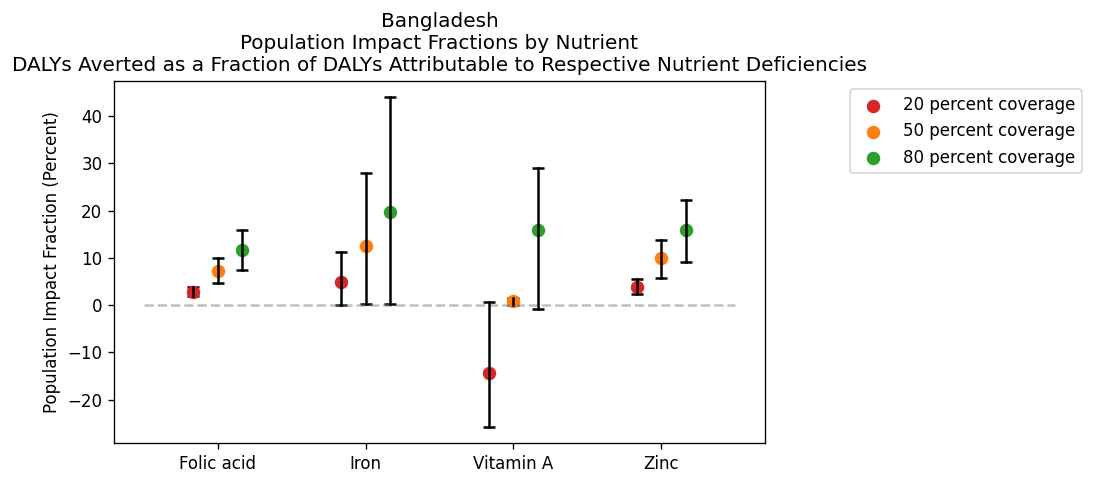

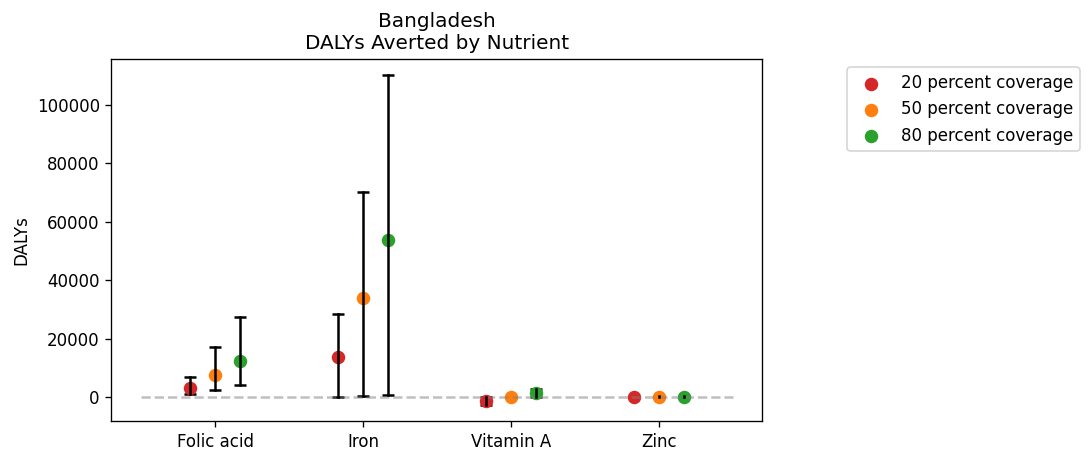

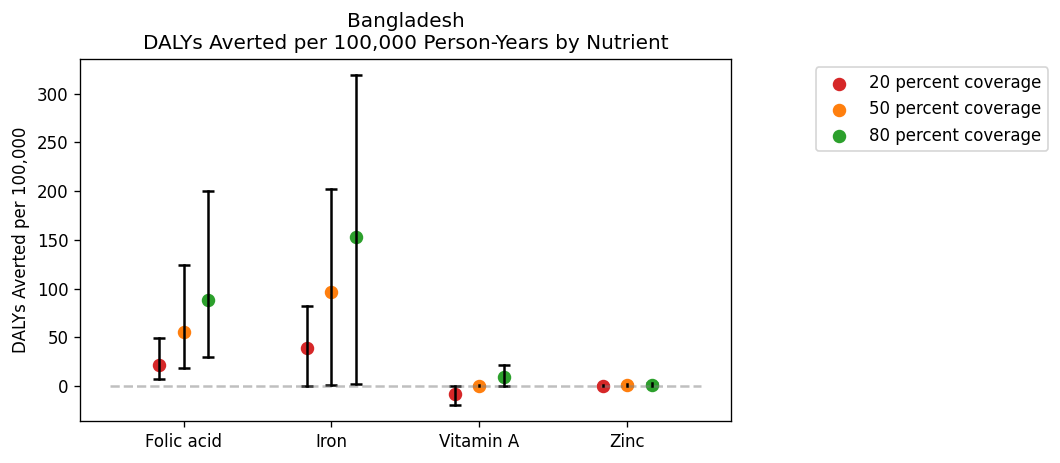

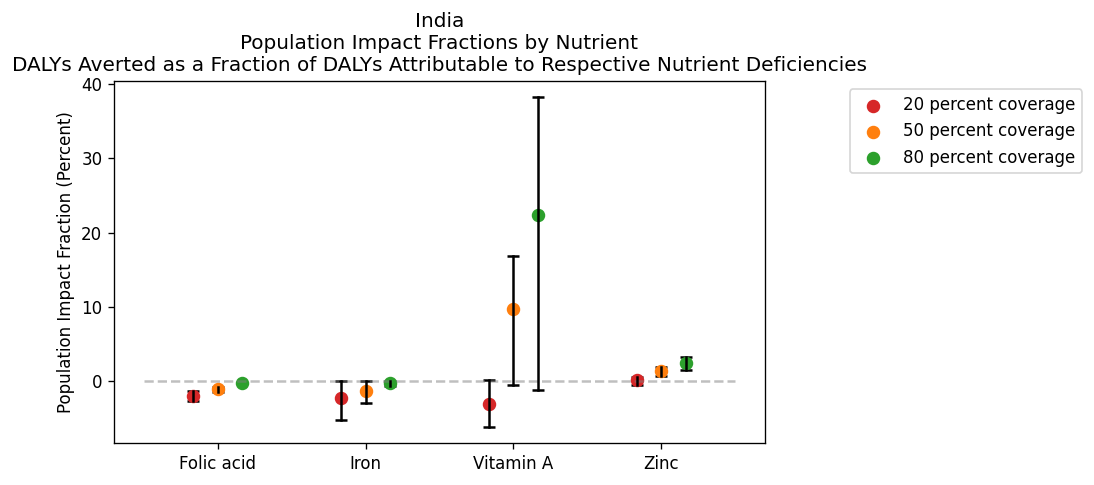

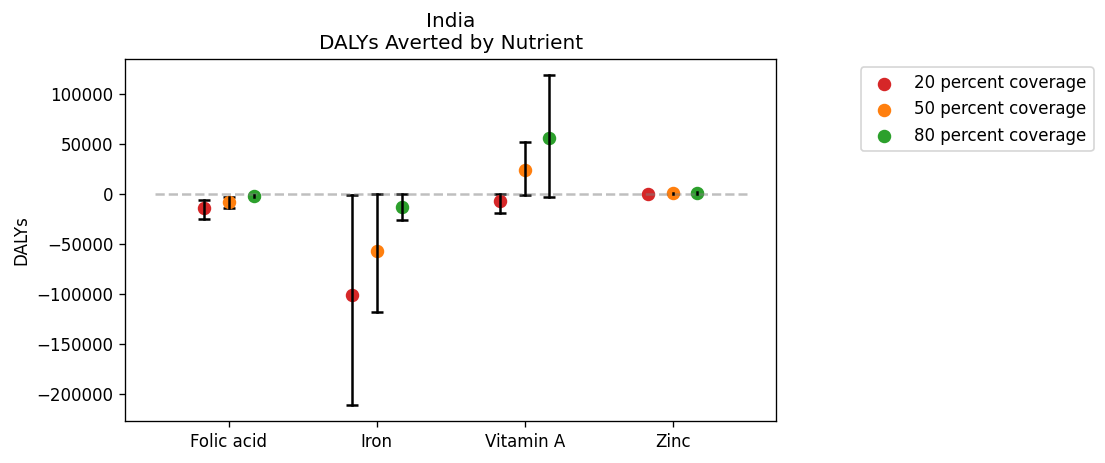

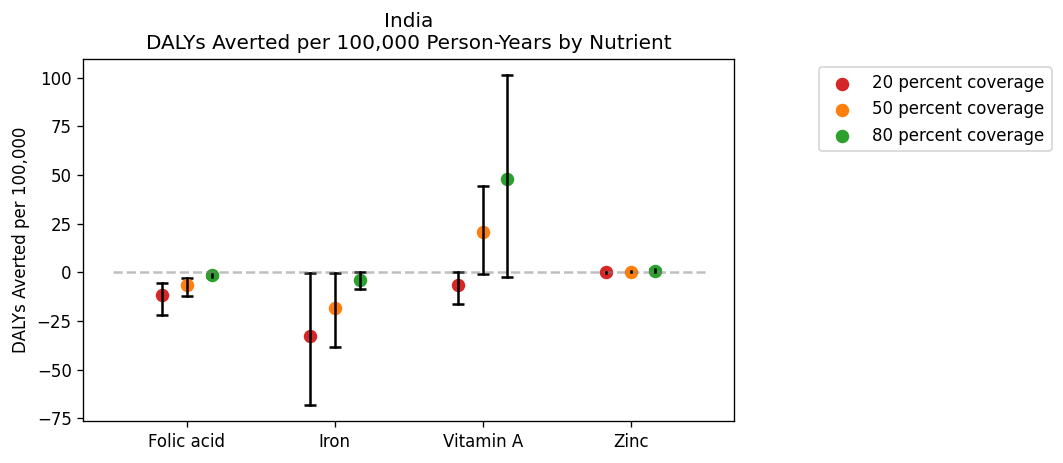

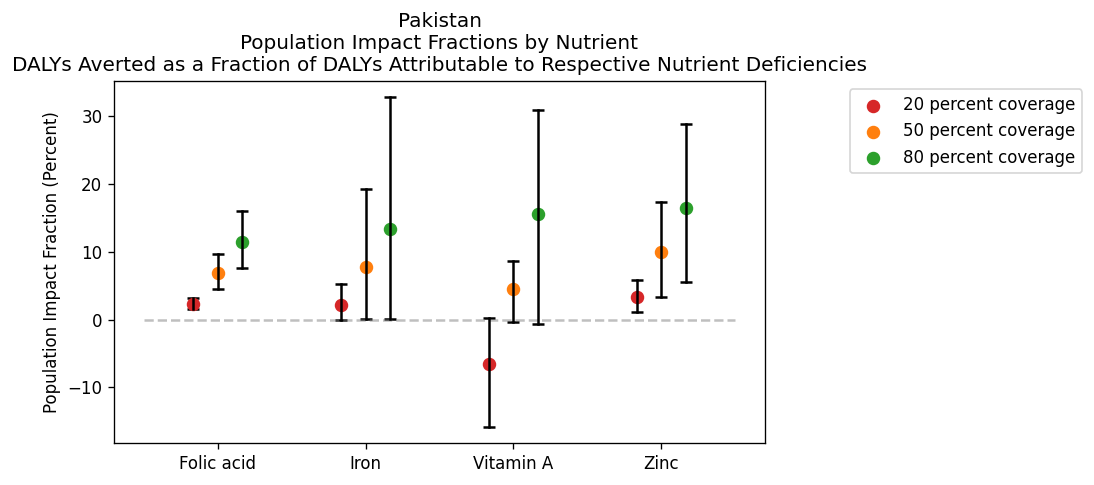

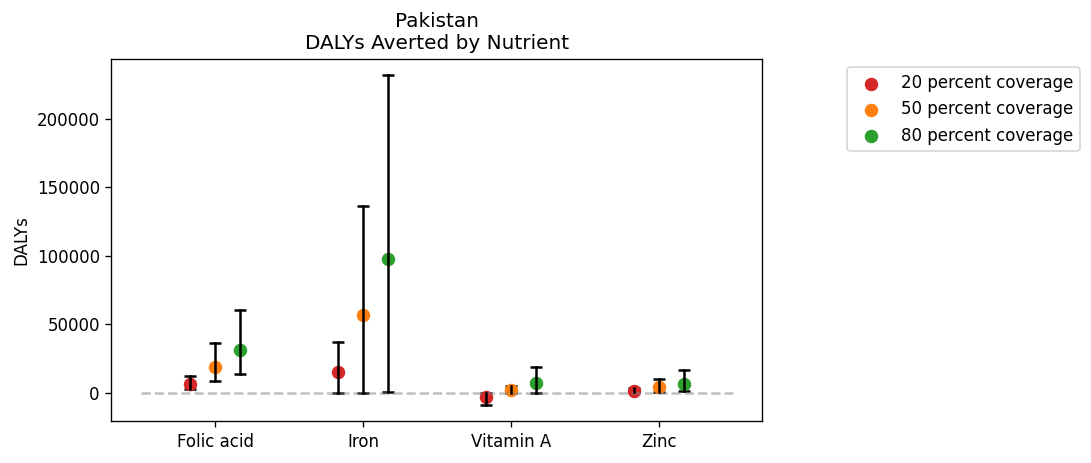

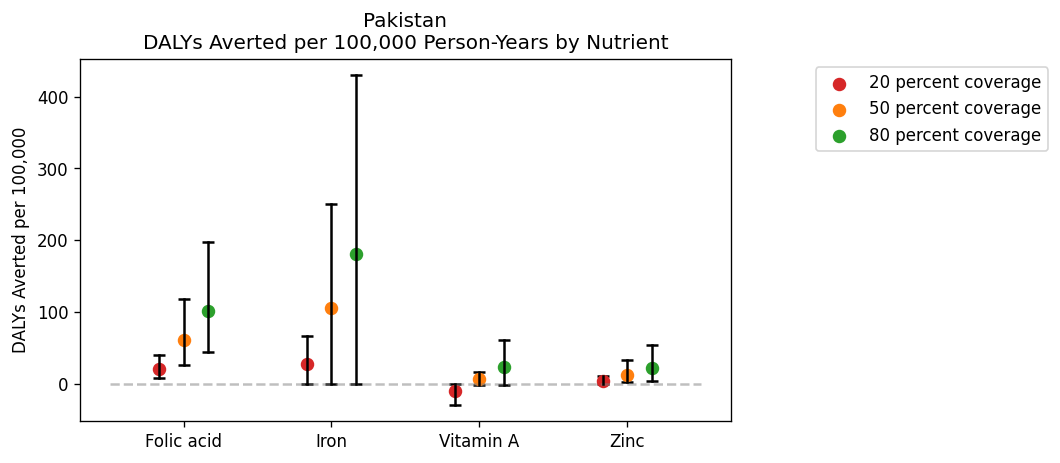

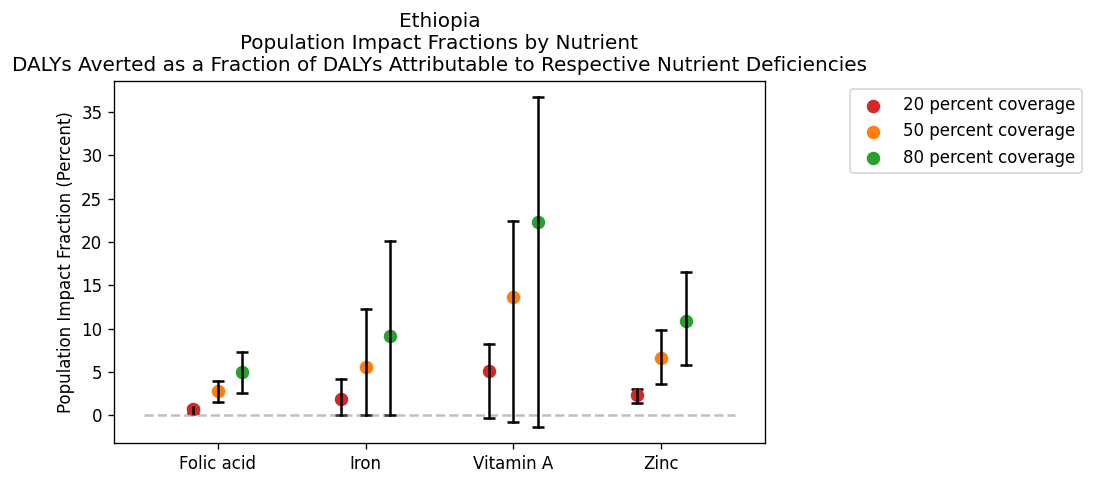

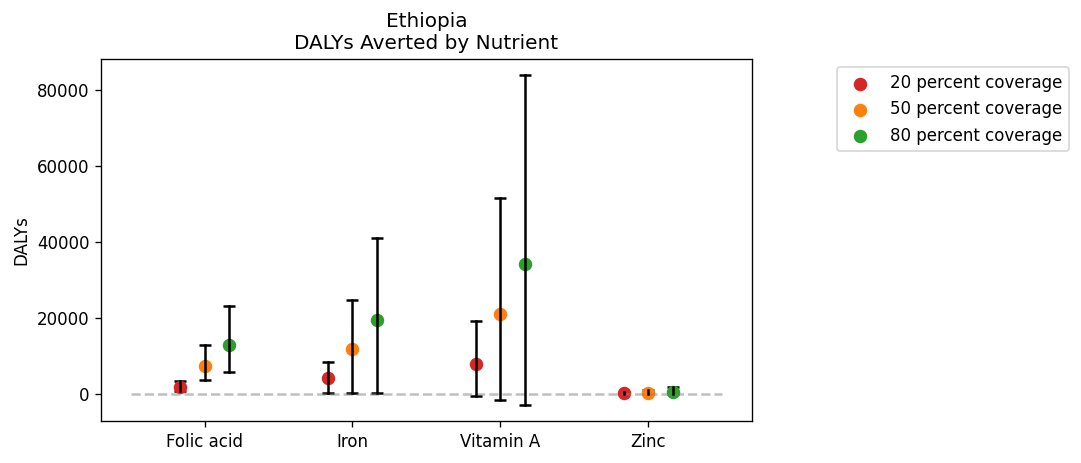

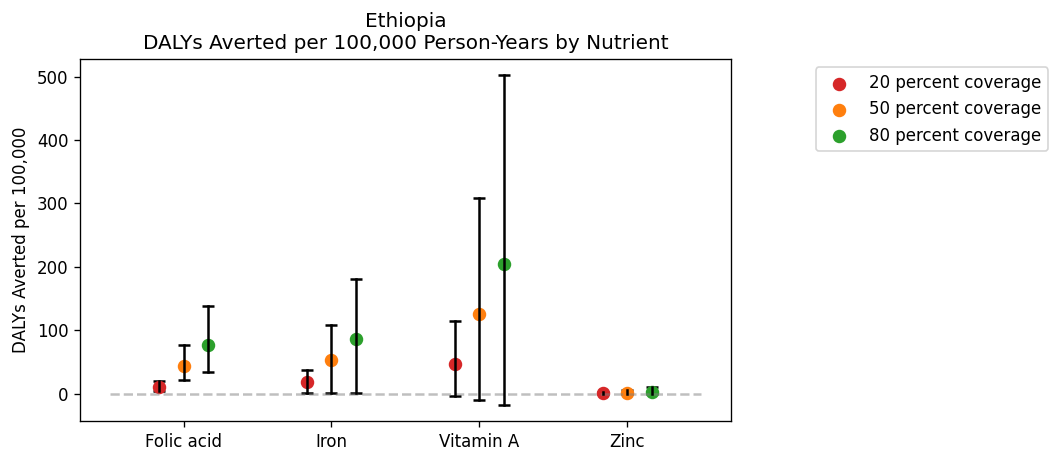

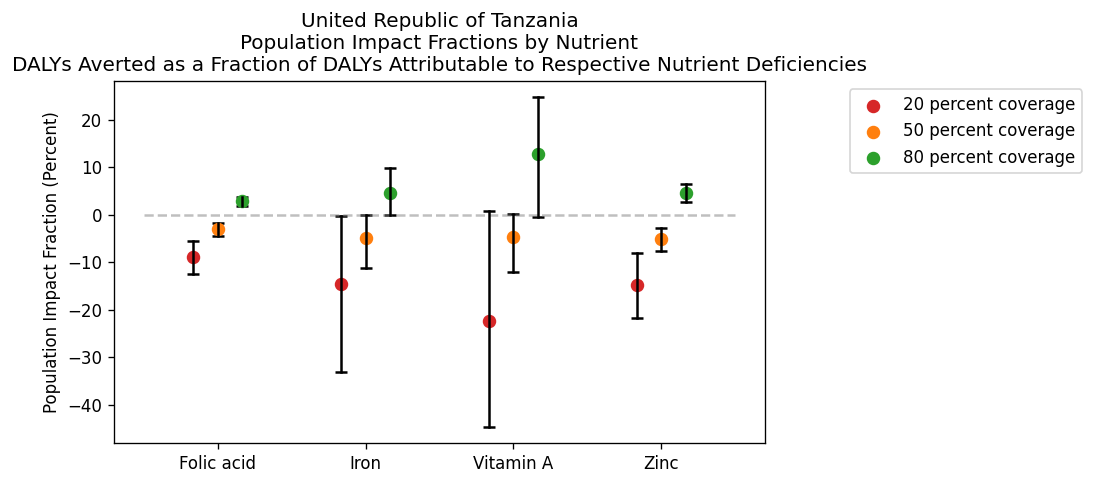

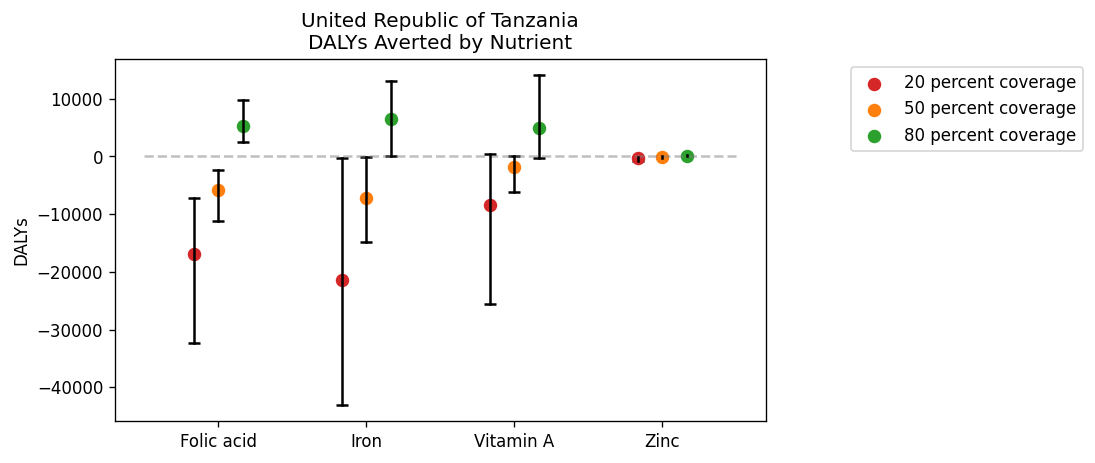

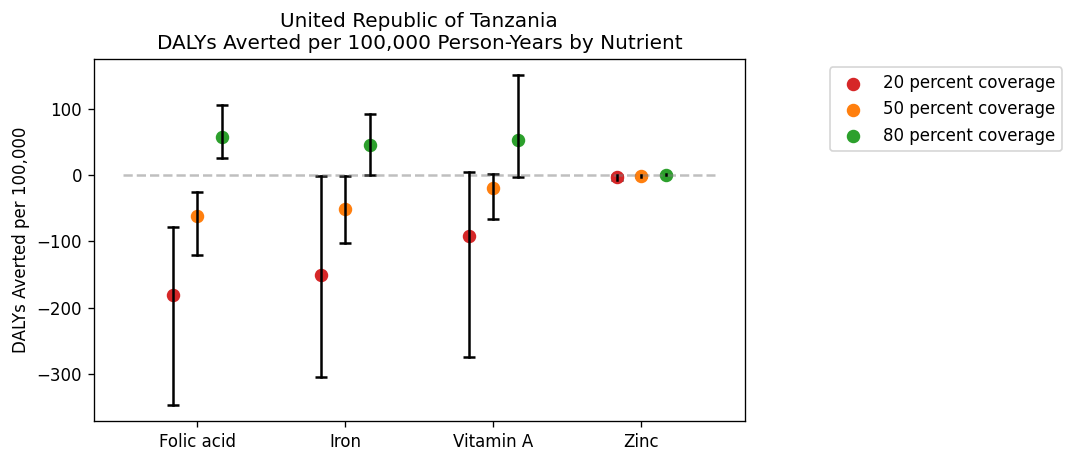

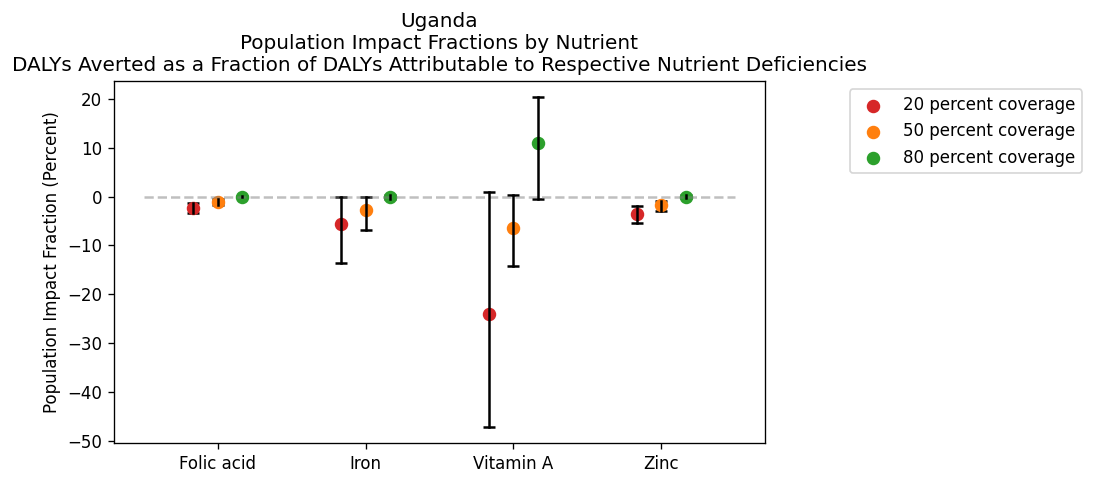

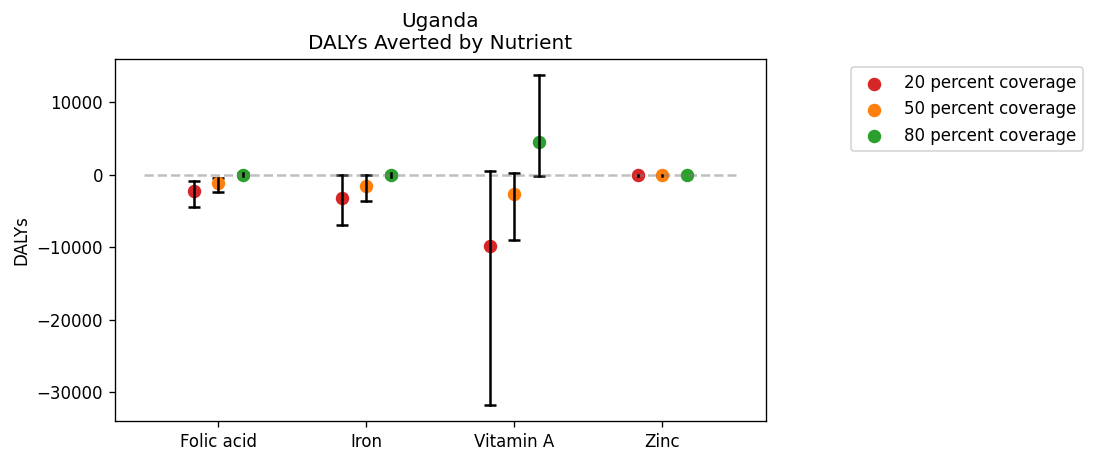

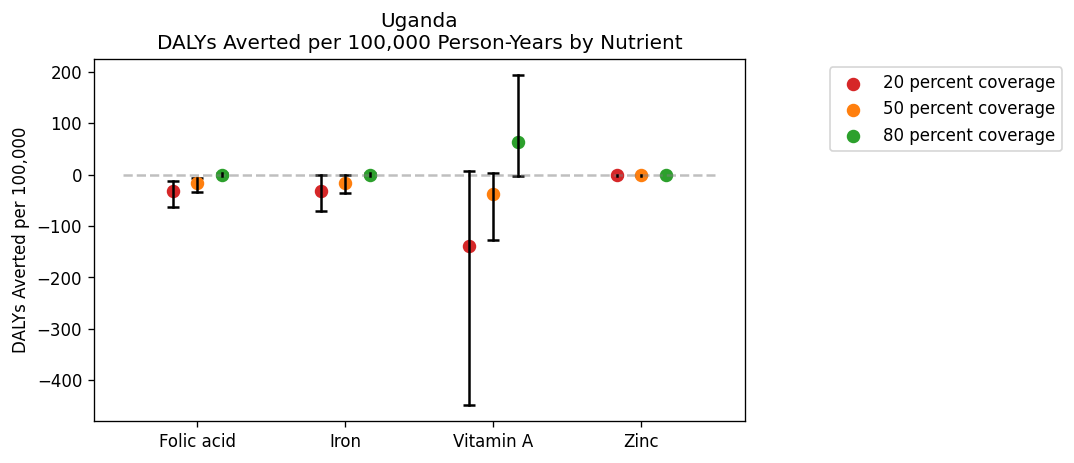

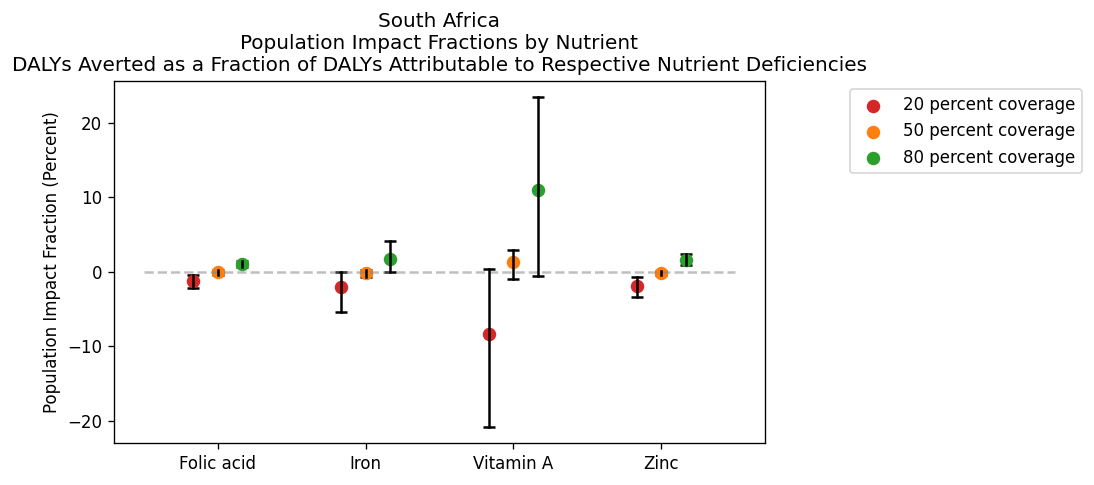

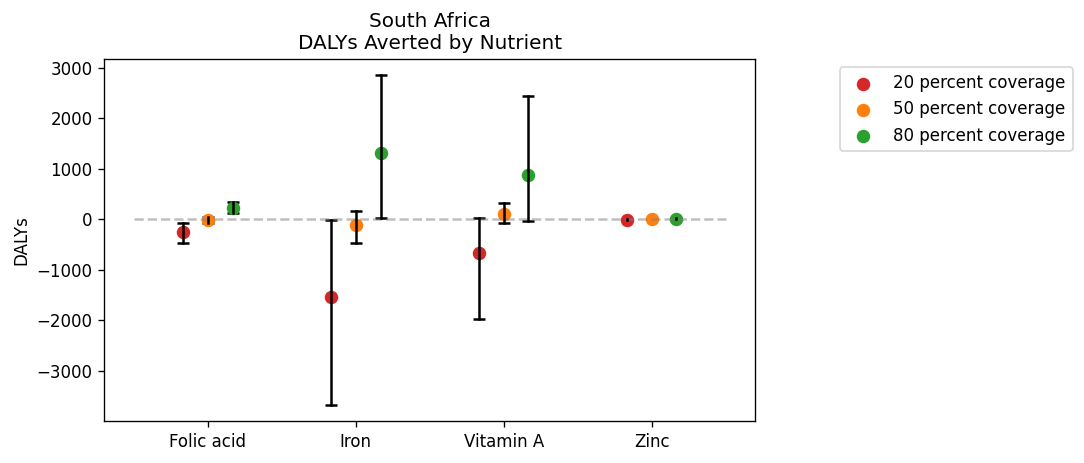

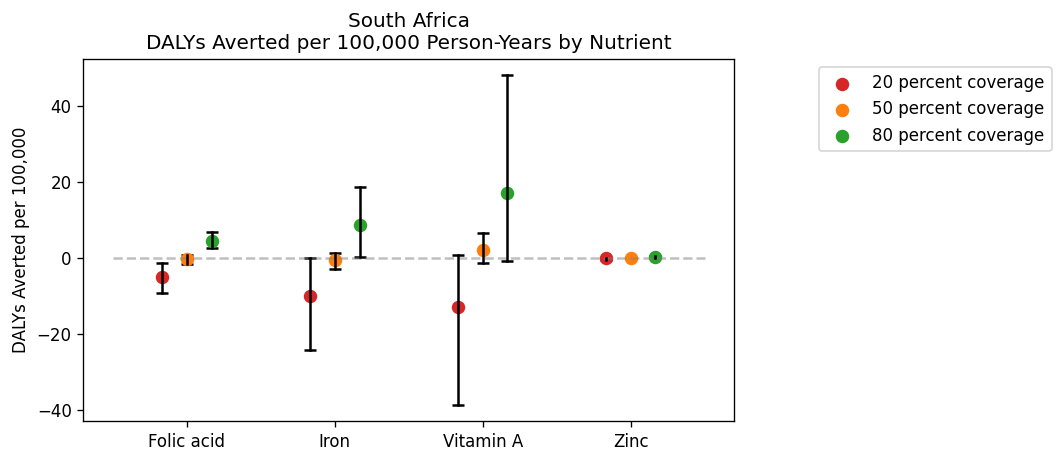

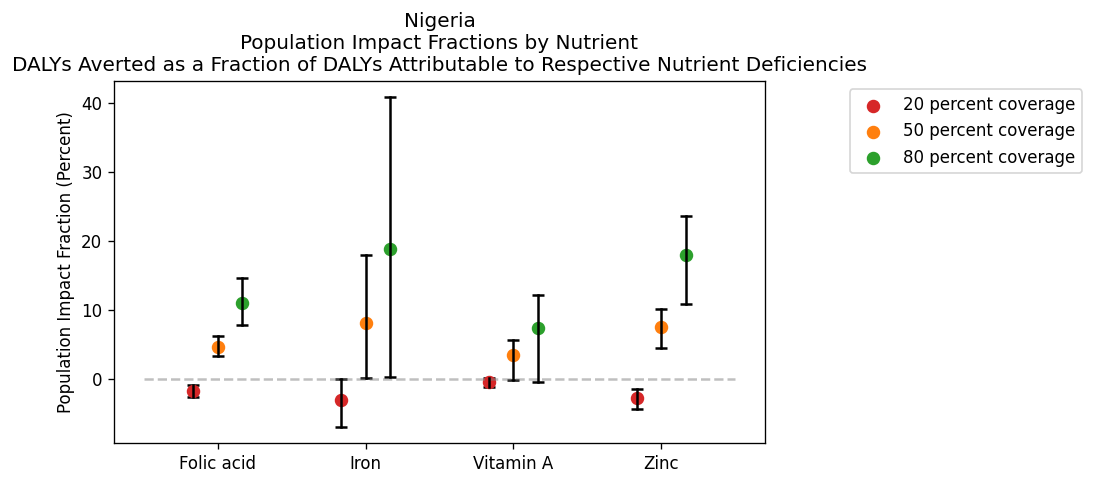

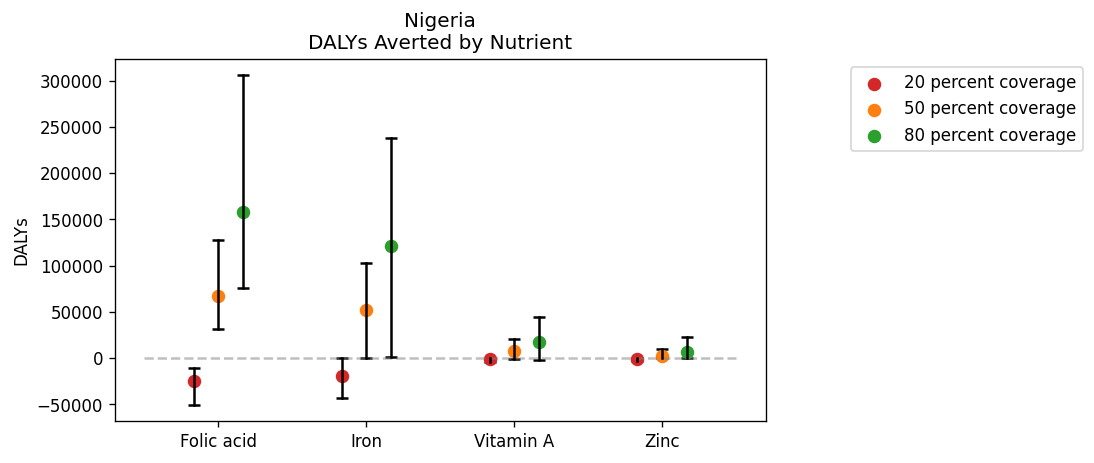

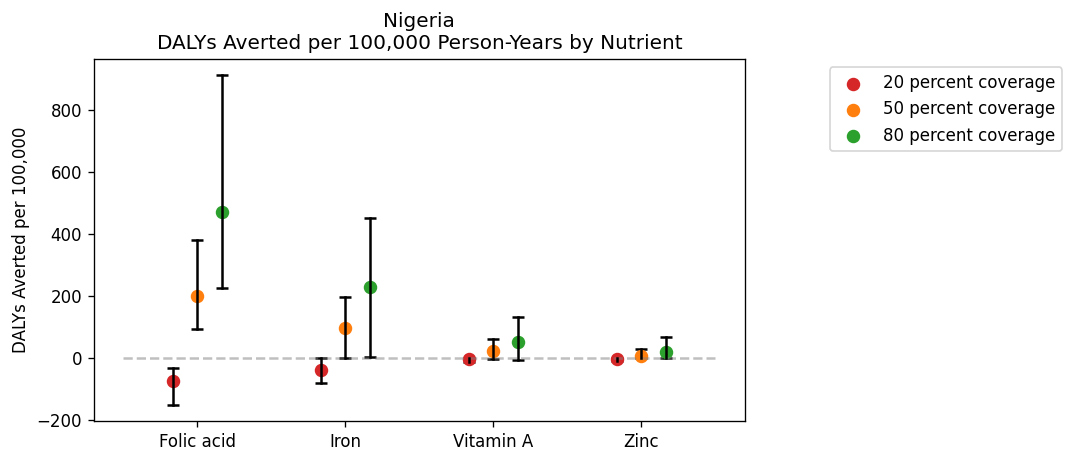

In [6]:
for location_id in results.location_id.unique():
    for measure in ['pif','counts_averted','rates_averted']:
        make_location_specific_plots(results, location_id, measure, coverage_levels)

# overall iron specific plots

In [ ]:
make_dot_plots((iron.loc[iron.measure=='counts_averted']
                .set_index([c for c in iron.columns if 'draw' not in c])), 
               'Iron', 'counts', coverage_levels, 'and Women of Reproductive Age\n(Anemia and Maternal Disorder DALYs)', 'iron_overall_counts_averted', wra=False)
make_dot_plots((iron.loc[iron.measure=='rates_averted']
                .set_index([c for c in iron.columns if 'draw' not in c])), 
               'Iron', 'rates', coverage_levels, 'and Women of Reproductive Age\n(Anemia and Maternal Disorder DALYs)', 'iron_overall_rates_averted', wra=False)
make_dot_plots((iron.loc[iron.measure=='pif']
                .set_index([c for c in iron.columns if 'draw' not in c])), 
               'Iron', 'pifs', coverage_levels, 'and Women of Reproductive Age - As a proportion of iron\ndeficiency attributable DALYs (excluding birthweight effects)', 'iron_overall_pif', wra=False)

# folic acid specific plots

In [ ]:
make_dot_plots((folic_acid.loc[folic_acid.measure=='counts_averted']
                .set_index([c for c in folic_acid.columns if 'draw' not in c])), 
               'Folic Acid', 'counts', coverage_levels, '', 'folic_acid_u5_counts_averted', wra=False)
make_dot_plots((folic_acid.loc[folic_acid.measure=='rates_averted']
                .set_index([c for c in folic_acid.columns if 'draw' not in c])), 
               'Folic Acid', 'rates', coverage_levels, '', 'folic_acid_u5_rates_averted', wra=False)
make_dot_plots((folic_acid.loc[folic_acid.measure=='pif']
                .set_index([c for c in folic_acid.columns if 'draw' not in c])), 
               'Folic Acid', 'pifs', coverage_levels, 'As a proportion of all neural tube defect DALYs', 'folic_acid_u5_pif', wra=False)